# Libraries

In [1]:
# import json file called config
import json
with open('config.json') as f:
    config = json.load(f)
TOKENIZER_ID = config['TOKENIZER_ID']
nrows = None if config['nrows'] == 0 else config['nrows']
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split # to separate the dataset.
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertModel



# Data access

In [2]:
data=pd.read_csv('title_text.csv',nrows=nrows)
#check if isFake column has unique values
print(data['isFake'].value_counts())

True     21417
False    21417
Name: isFake, dtype: int64


In [3]:
#we make everything lower.
data['text']=data['text'].apply(lambda x: x.lower())

## Modification du text en données numériques. (BERT)
Nous partons du principe que les données ont étés clean et que nous pouvons nous concerntrer à créer un model.

Comme les informations principales pour définir des Fake news et des vrai news, se base sur le texte et le titre, nous devons nous focaliser sur ces informations. Il faut ainsi que nous transformons le text et le titre en données afin que notre model puisse utiliser des données numériques pour trouver la bonne réponse. Nous allons utiliser le BERT tokenizer.

In [4]:
X = data['text']

# Create the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model_bert = BertModel.from_pretrained('bert-base-uncased')

# Set the maximum sequence length
max_seq_length = 512

# Truncate or pad the tokenized sequences
X = X.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_seq_length, truncation=True, padding='max_length'))
print(X)

0        [101, 2005, 3071, 2060, 2084, 2672, 2010, 5211...
1        [101, 8755, 1006, 26665, 1007, 1011, 1037, 764...
2        [101, 4199, 1006, 26665, 1007, 1011, 2280, 353...
3        [101, 1037, 9410, 2277, 2326, 2012, 1996, 2358...
4        [101, 1996, 8398, 2317, 2160, 2003, 2085, 3985...
                               ...                        
42829    [101, 1006, 26665, 1007, 1011, 6041, 7206, 270...
42830    [101, 2085, 2008, 6221, 8398, 2038, 2915, 2370...
42831    [101, 1996, 2214, 10539, 2962, 2087, 4141, 210...
42832    [101, 2899, 1006, 26665, 1007, 1011, 4883, 401...
42833    [101, 2899, 1006, 26665, 1007, 1011, 1057, 101...
Name: text, Length: 42834, dtype: object


In [5]:
y = data['isFake'].astype(int) #make it numerical
print(y.value_counts())

1    21417
0    21417
Name: isFake, dtype: int64


# Data split

In [6]:
# we separate the trdata into training test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [7]:
X_train = np.array(X_train.tolist())
y_train= np.array(y_train.tolist())
X_train.shape,y_train.shape

((34267, 512), (34267,))

In [8]:
X_test = np.array(X_test.tolist())
y_test= np.array(y_test.tolist())
X_test.shape,y_test.shape

((4283, 512), (4283,))

In [9]:
X_validation = np.array(X_validation.tolist())
y_validation= np.array(y_validation.tolist())
X_validation.shape,y_validation.shape

((4284, 512), (4284,))

# model naive bayes

In [39]:
NB = MultinomialNB()
NB.fit(X_train, y_train)
Accuracy = NB.score(X_test, y_test)
print("Accuracy Test Data: "+str(round(Accuracy*100,2))+"%")

Accuracy Test Data: 71.05%


In [38]:
y_pred_validation=NB.predict(X_validation)

# we calculate the accuracy of the model on the validation data
accuracy_validation=accuracy_score(y_validation, y_pred_validation)
print("Accuracy Validation Data: "+str(round(accuracy_validation*100),2)+"%")

Accuracy Validation Data: 72.57%


# Model optimization
we create a grid search algorithm, as such we are going the best hyperparameters for the model we start with param_grid with multiple parameters to test the most important parameter is `alpha`, which is the smoothing parameter for the model. It is used to handle unseen data, the higher the alpha the more smoothing is applied. Which in simple words means that the model will be less sensitive to the training data.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# On definit les parametres a tester
params_grid={'alpha': [0.01,0.05,0.1,0.5,1,5, 10,50,100,1000]}

# On definit le modele
model = MultinomialNB()

# On creer un scorer pour le grid search 
scorer = make_scorer(accuracy_score)

# Initialisation de la GridSearch pour trouver le meilleur C.
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=params_grid, # parametres à tester
    scoring=scorer, # scorer
    cv=5, # cv=5 pour utiliser la validation croisée à 5 folds 
    verbose=2, # verbose=2 pour afficher les logs
    n_jobs=-1, # n_jobs=-1 pour utiliser tous les coeurs du CPU
    return_train_score=True # pour afficher les scores d'entrainement
    )

# On lance les multiples entrainements.
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.0s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
                                   1000]},
             return_train_score=True, scoring=make_scorer(accuracy_score),
             verbose=2)

In [13]:
# Get the best combination of parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


Best parameters: {'alpha': 0.01}
Best score: 0.717541245389496


# Model Evaluation
on evalue les performances de notre model.

In [14]:
# On recupere le meilleur modele
best_model = grid_search.best_estimator_

In [15]:
#lancemenet de l'enrestristrement de la mémoire.
import psutil
import time
import os
def second_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return int(hours), int(minutes), int(seconds)

def bytes_to_Mo(mem_bytes):
    mem_kb = mem_bytes / 1024  # Convertir en kilooctets
    mem_mb = mem_kb / 1024  # Convertir en mégaoctets
    return mem_mb

process = psutil.Process(os.getpid())
mem_before_bytes = process.memory_info().rss

#lancement de l'enregistrement du temps d'entrainement.
start_time = time.time() 
# entrainement du modèle.
best_model.fit(X_train,y_train)
end_time = time.time()

#le temps écoulé 
elapsed_time= end_time - start_time

print(f"Temps d'entrainement (h | m | s) : {second_to_hms(elapsed_time)[0]} | {second_to_hms(elapsed_time)[1]} | {second_to_hms(elapsed_time)[2]}")

mem_after_bytes = process.memory_info().rss
#on convertit les bytes en Mo.
mem_bytes=mem_after_bytes - mem_before_bytes


print(f"Utilisation de la mémoire (Mo) : {bytes_to_Mo(mem_bytes)}")

Temps d'entrainement (h | m | s) : 0 | 0 | 0
Utilisation de la mémoire (Mo) : 0.0


In [16]:
# On predit les donnees de test
y_pred_test = best_model.predict(X_test)

In [35]:
# On calcule l'accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy Test Data: {round(accuracy_test*100,2)}%")

Accuracy Test Data: 71.05%


In [33]:
# On predit les donnees de validation
y_pred_validation = best_model.predict(X_validation)
# On calcule l'accuracy
accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print(f"Accuracy Validation Data: {round(accuracy_validation*100,2)}%")

Accuracy Validation Data: 72.57%


In [19]:
# on test toute les autres metric possible pour évaluer notre model de naive bayes.
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# on fait le classification_report
print(classification_report(y_validation, y_pred_validation))
#on obtient la precision,recall et f1_score
precision = precision_score(y_validation, y_pred_validation)
recall = recall_score(y_validation, y_pred_validation)
f1 = f1_score(y_validation, y_pred_validation)

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      2120
           1       0.72      0.76      0.74      2164

    accuracy                           0.73      4284
   macro avg       0.73      0.73      0.73      4284
weighted avg       0.73      0.73      0.73      4284



Interpretation:TODO <br>
Precision: TODO <br>
Recall: TODO<br>
F1-Score: TOOD<br>

Conclusion des parametres: TODO

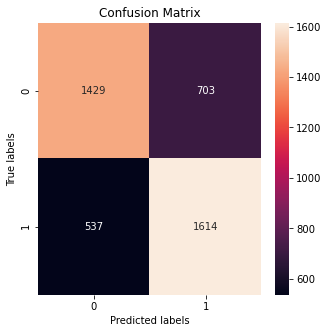

In [20]:
# On affiche la matrice de confusion en utilisant matplotlib
cm=confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d',)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
#we print the percentage of True Positive, True Negative, False Positive and False Negative
tn, fp, fn, tp = cm.ravel()
# Calculate the percentage of True Positive, True Negative, False Positive, and False Negative
total_samples = tn + fp + fn + tp
true_negative_percentage = (tn / total_samples) * 100
false_positive_percentage = (fp / total_samples) * 100
false_negative_percentage = (fn / total_samples) * 100
true_positive_percentage = (tp / total_samples) * 100

print(f"True Negative: {round(true_negative_percentage,2)}%")
print(f"False Positive: {round(false_positive_percentage,2)}%")
print(f"False Negative: {round(false_negative_percentage,2)}%")
print(f"True Positive: {round(true_positive_percentage,2)}%")

True Negative: 33.36%
False Positive: 16.41%
False Negative: 12.54%
True Positive: 37.68%


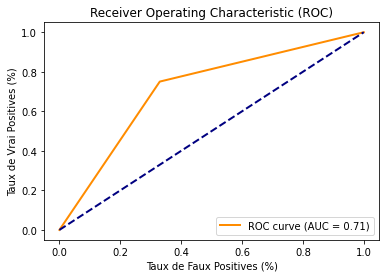

In [22]:
# On affiche la courbe ROC
from sklearn.metrics import roc_curve, roc_auc_score
#on obtient y_pred 
#on obtient la valeur roc_auc
roc_auc = roc_auc_score(y_test, y_pred_test)

fpr, tpr, _ = roc_curve(y_test, y_pred_test)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de Faux Positives (%)')
plt.ylabel('Taux de Vrai Positives (%)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Interpretation: TODO

# Test de performances sur des données générées par Téléchargé ailleurs

In [23]:
validation_data=pd.read_csv("data/validation_data.csv",nrows=nrows)
validation_data.head()

,Unnamed: 0,text,isFake
0,0,"Daniel Greenfield, a Shillman Journalism Fello...",False
1,1,Google Pinterest Digg Linkedin Reddit Stumbleu...,False
2,2,U.S. Secretary of State John F. Kerry said Mon...,True
3,3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",False
4,4,It's primary day in New York and front-runners...,True


In [24]:
validation_data=validation_data[['text','isFake']]


In [25]:
# Prepare the data
validation_data_X = validation_data['text'].apply(lambda x: x.lower())  # the text data
validation_data_y = validation_data['isFake']

# Tokenize the data using the BERT tokenizer
encoded_inputs = tokenizer(validation_data_X.tolist(), padding=True, truncation=True, max_length=max_seq_length, return_tensors='np')

# Get the input IDs and attention masks
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Use the trained model to make predictions on the dataset
predictions = best_model.predict(input_ids)


In [32]:
#we print the accuracy of the model
accuracy = accuracy_score(validation_data_y, predictions)
print(f"Accuracy different Dataset: {round(accuracy*100,2)}%")

Accuracy different Dataset: 57.51%


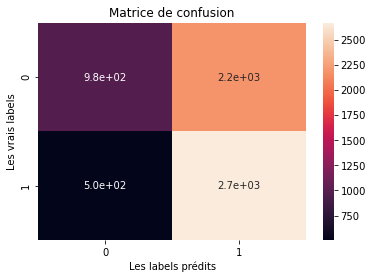

In [27]:
cm = confusion_matrix(validation_data_y,predictions)
#représentation graphique du résultat du meilleure model
sns.heatmap(cm, annot=True)
plt.xlabel('Les labels prédits')
plt.ylabel('Les vrais labels')
plt.title('Matrice de confusion')
plt.show()

In [30]:
#we print the percentage of True Positive, True Negative, False Positive and False Negative
tn, fp, fn, tp = cm.ravel()
# Calculate the percentage of True Positive, True Negative, False Positive, and False Negative
total_samples = tn + fp + fn + tp
true_negative_percentage = (tn / total_samples) * 100
false_positive_percentage = (fp / total_samples) * 100
false_negative_percentage = (fn / total_samples) * 100
true_positive_percentage = (tp / total_samples) * 100

print(f"True Negative: {round(true_negative_percentage,2)}%")
print(f"False Positive: {round(false_positive_percentage,2)}%")
print(f"False Negative: {round(false_negative_percentage,2)}%")
print(f"True Positive: {round(true_positive_percentage,2)}%")

True Negative: 15.42%
False Positive: 34.52%
False Negative: 7.97%
True Positive: 42.08%


# Conclusion